## **Demo: Liquor Identification**
<br>
Counterfeit is a huge problem in the global liquor and wine business. Identification of liquor is usually performed by sensory judgement (tasting and smelling), which is subjective and requires human expertise. Automatic identification by the sample's objective features may provide great potential value for low-cost counterfeit detection and product evaluation in liquor & wine industry.

For colorless and transparent liquors, such objective features are not easy to obtain from the sample's appearance, and there is no cost-effective way to accurately measure its "taste" and "aroma". One way to tackle this problem is to find unqiue measurable features that represents the liquor's chemical composition. Near-infrared spectroscopy (NIR) provides such compositional "fingerprint" information, as the sample's optical absorption in NIR range (wavelength 750 ~ 2500 nm) results from the molecular vibration of organic molecules in the sample. Therefore, NIR spectrum can be used as a characteristic feature for the classification of liquors.

Here is a simple demonstration of automatic identification of several types of liquors by supervised machine learning. The NIR spectra data are collected from each distinct liquor sample by a self-designed low-cost mini spectrometer sensor device.

==========================================================================================
<br>
<br>

### **1. Importing spectra data** 
<br>
Sample description: there are 5 types of liquor in this dataset:

Sample 0 ~ 59: Vodka, New Amsterdan®, 40 vol%, produced in Modesto, CA

Sample 60 ~ 118: Vodka, Absolut®, 40 vol%, produced in Ahus, Sweden

Sample 119 ~ 178: Vodka, Magic Moments, 40 vol%, produced in Rampur, India

Sample 179 ~ 238: Gin, New Amsterdan®, 40 vol%, produced in Modesto, CA

Sample 239 ~ 296: Fake liquor (40 vol% ethanol + water)

<br>
NIR absorption data are collected in the wavelength range: 1550 nm ~ 1850 nm
The absorption spectra data are organized in 'spectra.xlsx' (each sheet for an individual sample)


In [145]:
#Initial settings
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from pylab import rcParams
plt.rcParams['figure.figsize'] = 9, 6
plt.rcParams['font.size'] = 14
pd.set_option("display.max_rows", 15)

#====================
#Import spectra data
#====================
raw_data = pd.read_excel('spectra.xlsx')
spectra = []
sample_spectra = raw_data.iloc[:, 0: 2]
spectra.append(sample_spectra.set_index('wavelength'))
for i in range(1, 297):
    sample_spectra = raw_data.iloc[:, 3 * i : 3 * i + 2]
    spectra.append(sample_spectra.set_index('wavelength.{}'.format(i)))

Here is an example of the absorption spectrum data for sample 2:

In [146]:
display(spectra[2])

,absorbance.2
wavelength.2,
1850,0.690446
1849,0.686198
1848,0.681927
1847,0.678310
1846,0.674779
1845,0.671633
1844,0.668803
...,...
1556,0.791960


<br>
<br>

### **2. Spectra data visualization and preprocessing**

<br>
Let's visualize the absorption spectra of 5 types of liquor samples:

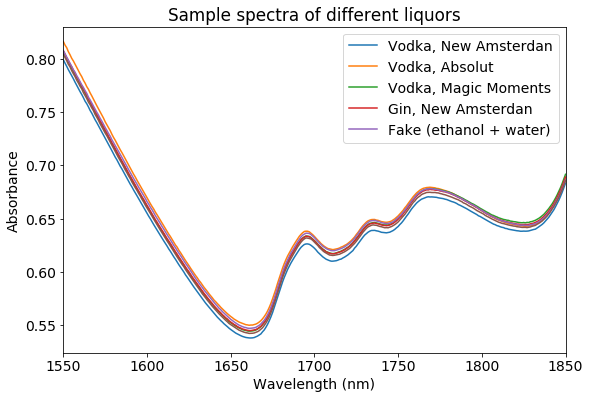

In [130]:
#=======================================
#Display spectra of each type of liquor
#=======================================
ax = spectra[0].plot()
for i in range(5):
    spectra[i * 60 + 30].plot(title = "Sample spectra of different liquors", ax = ax)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.legend(["Vodka, New Amsterdan", "Vodka, Absolut", "Vodka, Magic Moments", "Gin, New Amsterdan", "Fake (ethanol + water)"])
plt.show()

Aside from the original spectra data, derivative spectroscopy is commonly used to enhance the signal resoultion, detect hidden patterns and correct the background bias **[1]**. As a signal pre-processing step, here we also compute the 1st and 2nd derivative spectra for these samples. 

Notice that the signal constrast in the derivative spectra is higher than that in the original spectra data, although the noise also becomes higher after processing.

***Reference***: [1] Thomas C. O'Haver *et al*. "Derivative Spectroscopy and Its Applications In Analysis". *Anal. Proc.*, 1982, **19**, 22-46

<Figure size 648x432 with 0 Axes>

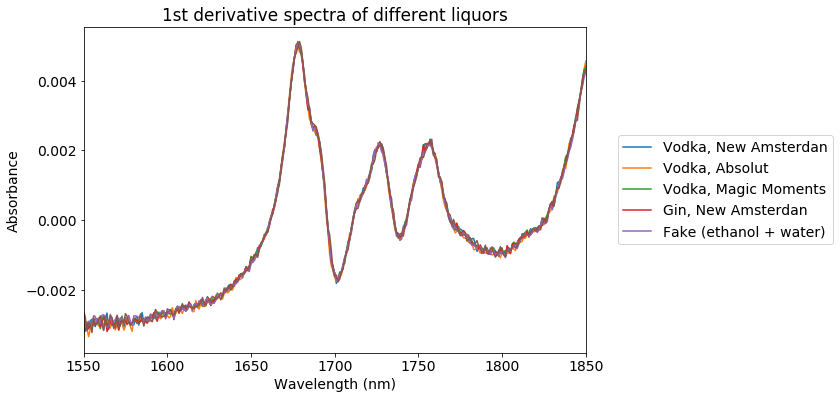

<Figure size 648x432 with 0 Axes>

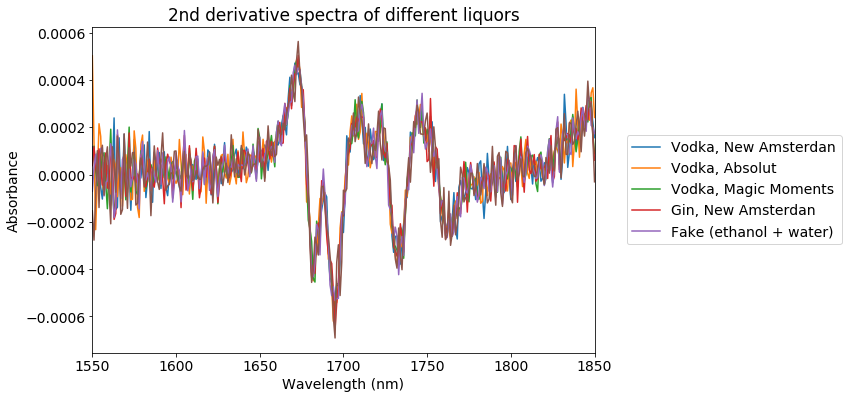

In [131]:
#==============================
#Spectra signal pre-processing
#==============================
#Function: return k-th derivative of spectrum data 
def derivative(data, k):
    result = data
    for i in range(k):
        grad = np.gradient(result, -1, axis = 0)
        result = pd.DataFrame(grad, index = result.index, columns = result.columns)
    return result

#Calculate the derivative of spectrum data
spectra_d1 = []
for i in range(len(spectra)):
    spectra_d1.append(derivative(spectra[i], 1))

spectra_d2 = []
for i in range(len(spectra)):
    spectra_d2.append(derivative(spectra[i], 2))
    
    
#Display 1st derivative plots
plt.figure()
ax = spectra_d1[0].plot()
for i in range(5):
    spectra_d1[i * 60 + 30].plot(title = "1st derivative spectra of different liquors", ax = ax)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.legend(["Vodka, New Amsterdan", "Vodka, Absolut", "Vodka, Magic Moments", "Gin, New Amsterdan", "Fake (ethanol + water)"], loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

#Display 2nd derivative plots
plt.figure()
ax = spectra_d2[0].plot()
for i in range(5):
    spectra_d2[i * 60 + 30].plot(title = "2nd derivative spectra of different liquors", ax = ax)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorbance")
ax.legend(["Vodka, New Amsterdan", "Vodka, Absolut", "Vodka, Magic Moments", "Gin, New Amsterdan", "Fake (ethanol + water)"], loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

<br>
<br>

### **3. Dimension reduction of spectra data**

<br>
The spectrum collected for each sample is a 301-dimensional vector (one absorbance value for each wavelength from 1550 nm to 1850 nm). The number of dimensions is about the same as the number of samples, which makes it almost impossible to train any classification models with good prediction accuracy.

Since spectrum is near-continuous data, we should be able to reduce the feature dimensions by principal component analysis (PCA) and extract the main features of the spectrum.

Let's start with the original spectra data:

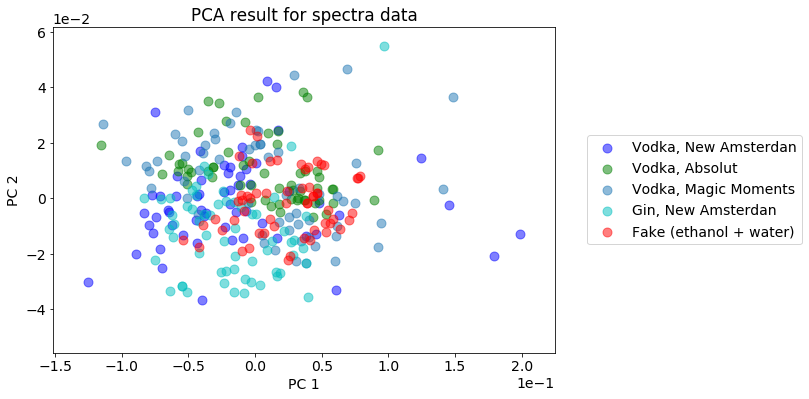

In [132]:
from sklearn.decomposition import PCA

#Tranform spectra data to one X matrix
def convert_X(spectra_list):
    result = spectra_list[0].transpose()
    for i in range(1, len(spectra_list)):
        result = pd.concat([result, spectra_list[i].transpose()])
    result = result.reset_index()
    result = result.drop('index', axis = 1)
    return result

#Parameters for plotting
color_dict = {
        0: 'b',
        1: 'g',
        2: '#1f77b4',
        3: 'c',
        4: 'r'
        }
label_dict = {
        0: "Vodka, New Amsterdan",
        1: "Vodka, Absolut",
        2: "Vodka, Magic Moments",
        3: "Gin, New Amsterdan",
        4: "Fake (ethanol + water)"
        }
sample_amounts = {
        1: 60,
        2: 59,
        3: 60,
        4: 60,
        5: 58
        }

#Original spectra:
spectra_X = convert_X(spectra)

pca = PCA(n_components = 2)
spectra_PCA = pca.fit_transform(spectra_X)

fig, ax = plt.subplots()
curr_index = 0
for i in range(5):
    ax.scatter(x = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 0],
               y = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 1],
               c = color_dict[i],
               s = 80, alpha = 0.5, 
               label = label_dict[i])
    curr_index += sample_amounts[i + 1]

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
plt.title("PCA result for spectra data")
plt.show()

We can see that the distributions of all 5 types of liquor largely overlap with each other, making it very difficult to identify any of them by the 2 principal components.

Let's try similar PCA on the 1st and 2nd derivative spectra:

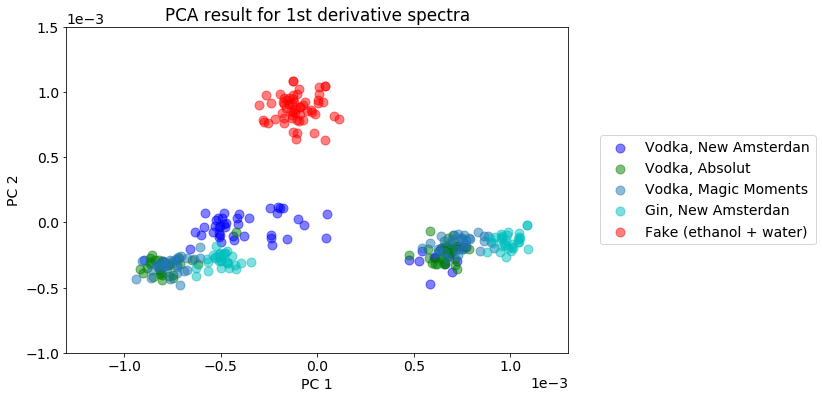

In [133]:
#1st derivative:
spectra_X = convert_X(spectra_d1)

pca = PCA(n_components = 2)
spectra_PCA = pca.fit_transform(spectra_X)

fig, ax = plt.subplots()
curr_index = 0
for i in range(5):
    ax.scatter(x = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 0],
               y = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 1],
               c = color_dict[i],
               s = 80, alpha = 0.5, 
               label = label_dict[i])
    curr_index += sample_amounts[i + 1]

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
plt.xlim(-0.0013, 0.0013)
plt.ylim(-0.001, 0.0015)
plt.title("PCA result for 1st derivative spectra")
plt.show()

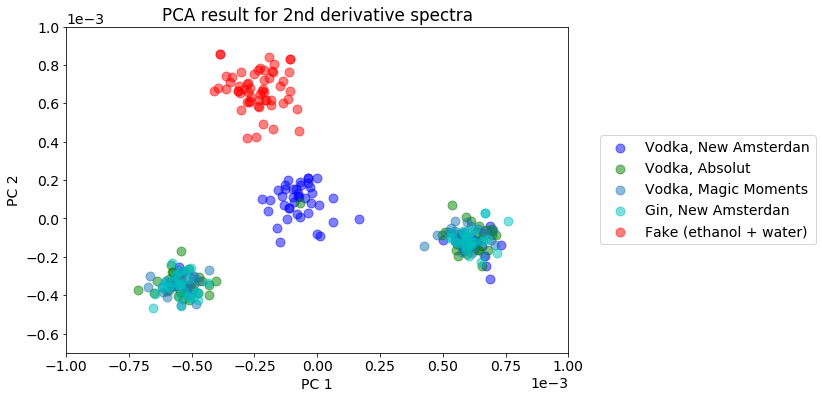

In [134]:
#2nd derivative:
spectra_X = convert_X(spectra_d2)

pca = PCA(n_components = 2)
spectra_PCA = pca.fit_transform(spectra_X)

fig, ax = plt.subplots()
curr_index = 0
for i in range(5):
    ax.scatter(x = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 0],
               y = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 1],
               c = color_dict[i],
               s = 80, alpha = 0.5, 
               label = label_dict[i])
    curr_index += sample_amounts[i + 1]

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
plt.xlim(-0.001, 0.001)
plt.ylim(-0.0007, 0.001)
plt.title("PCA result for 2nd derivative spectra")
plt.show()

In contrast to the original spectra, the results of derivative spectra show visible clustering according to the type of liquor, especially for the Fake samples and Vodka, New Amsterdan. Gin is also visually distinguishable in the result for 1st derivative spectra.

By further examing the 3rd principal component for 2nd derivative spectra, we can see that clustering will not significantly improve in the 3-D case.

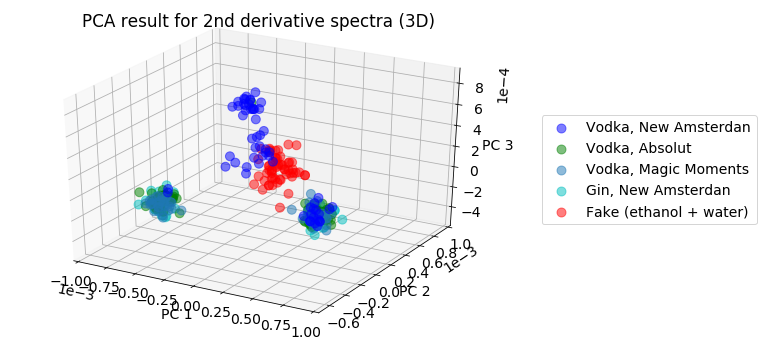

In [135]:
#3D visualization: 3 PCs for 2nd derivative data
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components = 3)
spectra_PCA = pca.fit_transform(spectra_X)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
curr_index = 0
for i in range(5):
    ax.scatter(xs = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 0],
               ys = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 1],
               zs = spectra_PCA[curr_index: curr_index + sample_amounts[i + 1], 2],
               c = color_dict[i],
               s = 80, alpha = 0.5, 
               label = label_dict[i])
    curr_index += sample_amounts[i + 1]

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
plt.xlim(-0.001, 0.001)
plt.ylim(-0.0007, 0.001)
plt.title("PCA result for 2nd derivative spectra (3D)")
plt.show()

<br>
<br>

### **4. Liquor classification**

<br>

**Task 1: Fake liquor detection**

The first objective is to see if we can use the spectra data to train a machine learning model that can automatically detect fake liquor from authentic ones. For this purpose, here we use the first two principal components of 2nd derivative spectra as sample features, and support vector machine (SVM) with radial basis kernel as the classifier model for supervised learning.

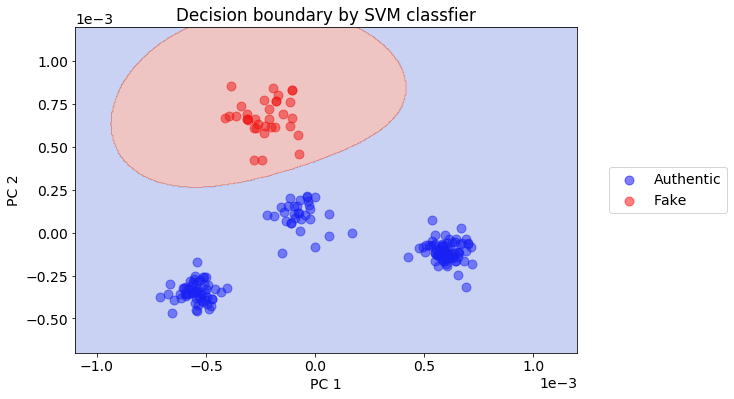

In [136]:
#=============================
#ML models for classification
#=============================
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#Task 1: Fake liquor detection

#Dataset preparation
spectra_X = convert_X(spectra_d2)
pca = PCA(n_components = 2)
spectra_PCA = pca.fit_transform(spectra_X)
dataset = pd.DataFrame(data = spectra_PCA, columns = ["pc_1", "pc_2"])
dataset["fake"] = [0] * 239 + [1] * 58

train, test = train_test_split(dataset, test_size = 0.33)
train_X = train.drop('fake', axis = 1)
train_Y = train['fake']
test_X = test.drop('fake', axis = 1)
test_Y = test['fake']

#Train SVM classifier model
clf = SVC(kernel = 'rbf', gamma = 'scale')
clf.fit(train_X, train_Y)

#Visualization of the SVM decision boundary based on decision function
#Contour plotting: code partially adopted from Saptashwa
#Source: https://towardsdatascience.com/visualizing-support-vector-machine-decision-boundary-69e7591dacea

def plot_contours(ax, clf, xx, yy, **params):
    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h = .000005):
    x_min, x_max = -0.0011, 0.0012
    y_min, y_max = -0.0007, 0.0012
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

X0, X1 = train_X["pc_1"], train_X["pc_2"]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
ax.scatter(x = train[train['fake'] == 0]["pc_1"], y = train[train['fake'] == 0]["pc_2"], s = 80, alpha = 0.5, c = 'b', label = 'Authentic')
ax.scatter(x = train[train['fake'] == 1]["pc_1"], y = train[train['fake'] == 1]["pc_2"], s = 80, alpha = 0.5, c = 'r', label = 'Fake')
plot_contours(ax, clf, xx, yy, cmap = 'coolwarm', alpha = 0.3)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.xlim(-0.0011, 0.0012)
plt.ylim(-0.0007, 0.0012)
plt.title("Decision boundary by SVM classfier")

plt.show()

SVM model gives a very clear decision boundary for the authentic and fake liquor samples. This model demonstrates 100% prediction accuracy on test data, as shown by the confusion matrix below:

In [137]:
#Output confusion matrix for the classification test results
c_matrix = pd.DataFrame(confusion_matrix(test_Y, clf.predict(test_X)), index = ["Predict: Authentic", "Predict: Fake"], columns = ["Authentic", "Fake"])
accuracy =  [100 * c_matrix.iloc[i, i] / c_matrix.iloc[:, i].sum() for i in range(len(c_matrix.index))]
c_matrix.loc["Prediction Accuracy (%)"] = accuracy
display(c_matrix)

,Authentic,Fake
Predict: Authentic,75.0,0.0
Predict: Fake,0.0,24.0
Prediction Accuracy (%),100.0,100.0


<br>

**Task 2: Recognition of liquor types**

After successfully detecting fake from authentic liquors, the second objective is to see if we can further identify the type or even brand of any given liquor sample. By observing the PCA result of 2nd derivative spectra, the clustering of Vodka (New Amsterdan), Fake liquor and other liquors are clearly distinguishable, while the 3 types in the "other liquors" category are hard to differentiate. Let's try 3-class recognition first:

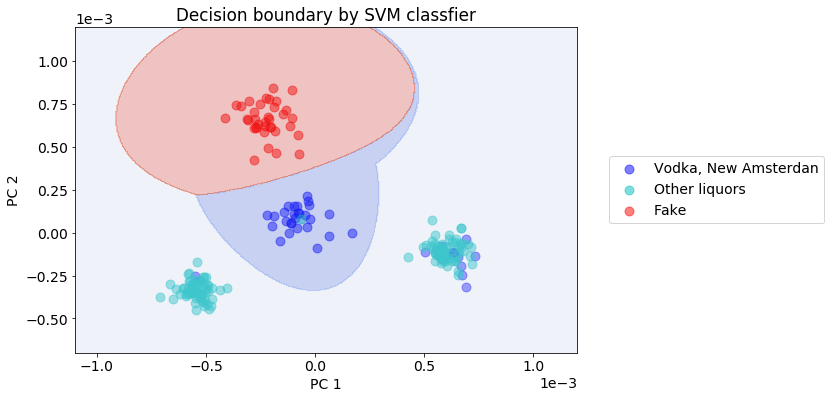

In [138]:
#Task 2: Recoginition of liquor type
#Observation on PCA plot (d2): type 1, type 5 and type 2, 3, 4 may be classified (3 classes)

#Dataset preparation
spectra_X = convert_X(spectra_d2)
pca = PCA(n_components = 2)
spectra_PCA = pca.fit_transform(spectra_X)
dataset = pd.DataFrame(data = spectra_PCA, columns = ["pc_1", "pc_2"])
dataset["type"] = [1] * 60 + [2] * 179 + [3] * 58

train, test = train_test_split(dataset, test_size = 0.33)
train_X = train.drop('type', axis = 1)
train_Y = train['type']
test_X = test.drop('type', axis = 1)
test_Y = test['type']

#Train SVM classifier model
clf = SVC(kernel = 'rbf', gamma = 'scale', decision_function_shape = 'ovr')
clf.fit(train_X, train_Y)

#Visualization of the SVM decision boundary based on decision function
X0, X1 = train_X["pc_1"], train_X["pc_2"]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
ax.scatter(x = train[train['type'] == 1]["pc_1"], y = train[train['type'] == 1]["pc_2"], s = 80, c = 'b', alpha = 0.5, label = 'Vodka, New Amsterdan')
ax.scatter(x = train[train['type'] == 2]["pc_1"], y = train[train['type'] == 2]["pc_2"], s = 80, c = 'c', alpha = 0.5, label = 'Other liquors')
ax.scatter(x = train[train['type'] == 3]["pc_1"], y = train[train['type'] == 3]["pc_2"], s = 80, c = 'r', alpha = 0.5, label = 'Fake')
plot_contours(ax, clf, xx, yy, cmap = 'coolwarm', alpha = 0.3)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.xlim(-0.0011, 0.0012)
plt.ylim(-0.0007, 0.0012)
plt.title("Decision boundary by SVM classfier")

plt.show()

SVM model gives a fairly good classification among the three classes, although some Vodka (New Amsterdan) samples are not recognized (classified as "other liquors"). The prediction accuracy on test samples are shown in the Confusion Matrix below.

In [139]:
#Output confusion matrix for the classification test results
c_matrix = pd.DataFrame(confusion_matrix(test_Y, clf.predict(test_X)), index = ["Predict: New Amsterdan", "Predict: Others", "Predict: Fake"], columns = ["New Amsterdan", "Others", "Fake"])
accuracy =  [100 * c_matrix.iloc[i, i] / c_matrix.iloc[:, i].sum() for i in range(len(c_matrix.index))]
c_matrix.loc["Prediction Accuracy (%)"] = accuracy
display(c_matrix)

,New Amsterdan,Others,Fake
Predict: New Amsterdan,13.0,3.0000,0.0
Predict: Others,0.0,61.0000,0.0
Predict: Fake,0.0,0.0000,22.0
Prediction Accuracy (%),100.0,95.3125,100.0


If we revisit the PCA result of 1st dericative spectra, you may find that the data points of Gin may also be separable from the other two Vodka types (this is intuitive since Gin is a different type of liquor with Vodka). If we train a SVM classifier with the 1st derivative spectra, we may achieve 4-class recognition instead of just 3-class:

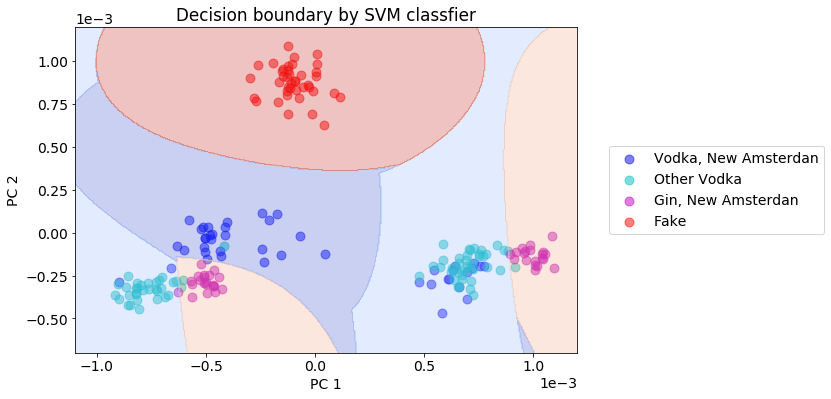

In [140]:
#Observation on PCA plot (d1): type 1, type 4, type 5 and type 2, 3 may be classified (4 classes)
#Dataset preparation
spectra_X = convert_X(spectra_d1)
pca = PCA(n_components = 2)
spectra_PCA = pca.fit_transform(spectra_X)
dataset = pd.DataFrame(data = spectra_PCA, columns = ["pc_1", "pc_2"])
dataset["type"] = [1] * 60 + [2] * 119 + [3] * 60 + [4] * 58

train, test = train_test_split(dataset, test_size = 0.33)
train_X = train.drop('type', axis = 1)
train_Y = train['type']
test_X = test.drop('type', axis = 1)
test_Y = test['type']

#Train SVM classifier model
clf = SVC(kernel = 'rbf', gamma = 'scale', decision_function_shape = 'ovr')
clf.fit(train_X, train_Y)

#Visualization of the SVM decision boundary based on decision function
X0, X1 = train_X["pc_1"], train_X["pc_2"]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
ax.scatter(x = train[train['type'] == 1]["pc_1"], y = train[train['type'] == 1]["pc_2"], s = 80, c = 'b', alpha = 0.5, label = 'Vodka, New Amsterdan')
ax.scatter(x = train[train['type'] == 2]["pc_1"], y = train[train['type'] == 2]["pc_2"], s = 80, c = 'c', alpha = 0.5, label = 'Other Vodka')
ax.scatter(x = train[train['type'] == 3]["pc_1"], y = train[train['type'] == 3]["pc_2"], s = 80, c = 'm', alpha = 0.5, label = 'Gin, New Amsterdan')
ax.scatter(x = train[train['type'] == 4]["pc_1"], y = train[train['type'] == 4]["pc_2"], s = 80, c = 'r', alpha = 0.5, label = 'Fake')
plot_contours(ax, clf, xx, yy, cmap = 'coolwarm', alpha = 0.3)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.ticklabel_format(style = 'sci', scilimits = (0, 0))
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.xlim(-0.0011, 0.0012)
plt.ylim(-0.0007, 0.0012)
plt.title("Decision boundary by SVM classfier")

plt.show()

The prediction accuracy is shown in the Confusion Matrix below:

In [141]:
#Output confusion matrix for the classification test results
c_matrix = pd.DataFrame(confusion_matrix(test_Y, clf.predict(test_X)), index = ["Predict: Vodka, NA", "Predict: Other Vodka", "Predict: Gin, NA", "Predict: Fake"], columns = ["Vodka, NA", "Other Vodka", "Gin, NA", "Fake"])
accuracy =  [100 * c_matrix.iloc[i, i] / c_matrix.iloc[:, i].sum() for i in range(len(c_matrix.index))]
c_matrix.loc["Prediction Accuracy (%)"] = accuracy
display(c_matrix)

,"Vodka, NA",Other Vodka,"Gin, NA",Fake
"Predict: Vodka, NA",12.0,4.0,0.000000,0.0
Predict: Other Vodka,0.0,44.0,2.000000,0.0
"Predict: Gin, NA",0.0,2.0,17.000000,0.0
Predict: Fake,0.0,0.0,0.000000,18.0
Prediction Accuracy (%),100.0,88.0,89.473684,100.0


<br>
<br>

### **5. Summary**

<br>
Above is a demonstration that different types of liquors can be automatically identified by supervised machine learning models based on their NIR absorption spectra data. After pre-processing spectra signals by taking 1st/2nd order derivative, feature dimension reduction by PCA and classification by SVM models, liquor identification can reach a high prediction accuracy of >90% (~100% for fake detection). To further optimize the prediction accuracy, we can improve the data signal-to-noise ratio by applying smoothing filters (e.g., Savitzky-Golay smoothing) in the pre-processing step, and increase the number of training samples for building the classifier model.